In [17]:
import math
import numpy
from scipy import integrate
from matplotlib import pyplot

In [18]:
with open ('./resources/MainFoil_N=200.csv') as file_name:
          p, q = numpy.loadtxt(file_name, dtype=float, delimiter=',', unpack=True)
with open ('./resources/FlapFoil_N=200.csv') as file_name:
         u, v = numpy.loadtxt(file_name, dtype=float, delimiter=',', unpack=True)

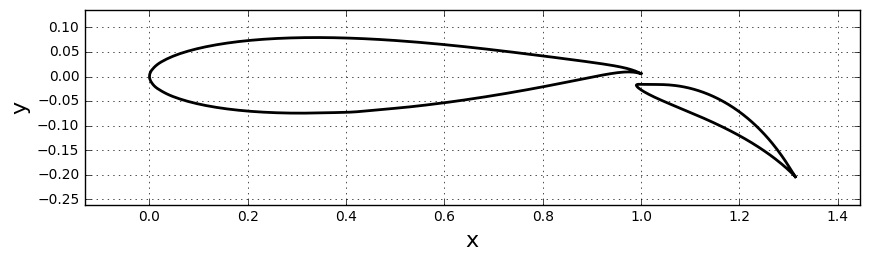

In [19]:
# plots the geometry
%matplotlib inline

val_x, val_y = 0.1, 0.2
x_min, x_max = p.min(), u.max()
y_min, y_max = v.min(), q.max()
x_start, x_end = x_min-val_x*(x_max-x_min), x_max+val_x*(x_max-x_min)
y_start, y_end = y_min-val_y*(y_max-y_min), y_max+val_y*(y_max-y_min)

size = 10
pyplot.figure(figsize=(size, (y_end-y_start)/(x_end-x_start)*size))
pyplot.grid(True)
pyplot.xlabel('x', fontsize=16)
pyplot.ylabel('y', fontsize=16)
pyplot.xlim(x_start, x_end)
pyplot.ylim(y_start, y_end)
pyplot.plot(p, q, color='k', linestyle='-', linewidth=2);
pyplot.plot(u, v, color='k', linestyle='-', linewidth=2);

In [20]:
class Panel:
    """Contains information related to one panel."""
    def __init__(self, xa, ya, xb, yb):
        """Creates a panel.
        
        Arguments
        ---------
        xa, ya -- Cartesian coordinates of the first end-point.
        xb, yb -- Cartesian coordinates of the second end-point.
        """
        self.xa, self.ya = xa, ya
        self.xb, self.yb = xb, yb
        
        self.xc, self.yc = (xa+xb)/2, (ya+yb)/2       # control-point (center-point)
        self.length = math.sqrt((xb-xa)**2+(yb-ya)**2)     # length of the panel
        
        # orientation of the panel (angle between x-axis and panel's normal)
        if xb-xa <= 0.:
            self.beta = math.acos((yb-ya)/self.length)
        elif xb-xa > 0.:
            self.beta = math.pi + math.acos(-(yb-ya)/self.length)
        
        # location of the panel
        if self.beta <= math.pi:
            self.loc = 'upper'
        else:
            self.loc = 'lower'
        
        self.sigma = 0.                             # source strength
        self.vt = 0.                                # tangential velocity
        self.cp = 0.                                # pressure coefficient

In [21]:
N = 200
panels = numpy.empty(N, dtype=object)
flappanels = numpy.empty(N, dtype=object)
for i in range(N):
    panels[i] = Panel(p[i], q[i], p[i+1], q[i+1])
for j in range(N):
    flappanels[j] = Panel(u[j], v[j], u[j+1], v[j+1])

In [22]:
allpanels = numpy.append(panels,flappanels)

In [23]:
def integral(x, y, panel, dxdz, dydz):
    """Evaluates the contribution of a panel at one point.
    
    Arguments
    ---------
    x, y -- Cartesian coordinates of the point.
    panel -- panel which contribution is evaluated.
    dxdz -- derivative of x in the z-direction.
    dydz -- derivative of y in the z-direction.
    
    Returns
    -------
    Integral over the panel of the influence at one point.
    """
    def func(s):
        return ( ((x - (panel.xa - math.sin(panel.beta)*s))*dxdz 
                  + (y - (panel.ya + math.cos(panel.beta)*s))*dydz)
                / ((x - (panel.xa - math.sin(panel.beta)*s))**2 
                   + (y - (panel.ya + math.cos(panel.beta)*s))**2) )
    return integrate.quad(lambda s:func(s), 0., panel.length)[0]

In [24]:
def source_contribution_normal(panels):
    """Builds the source matrix.
    
    Arguments
    ---------
    panels -- array of panels.
    
    Returns
    -------
    A -- NxN matrix (N is the number of panels).
    """
    A = numpy.empty((panels.size, panels.size), dtype=float)
    numpy.fill_diagonal(A, 0.5)
    
    for i, p_i in enumerate(panels):
        for j, p_j in enumerate(panels):
            if i != j:
                A[i,j] = 0.5/math.pi*integral(p_i.xc, p_i.yc, 
                                              p_j, 
                                              math.cos(p_i.beta), math.sin(p_i.beta))
    
    return A

In [25]:
def vortex_contribution_normal(panels):
    """Builds the vortex contribution matrix for the normal velocity.
    
    Parameters
    ----------
    panels: Numpy 1d array (Panel object)
        List of panels.
    
    Returns
    -------
    A: Numpy 2d array (float)
        Vortex contribution matrix.
    """
    A = numpy.empty((panels.size, panels.size), dtype=float)
    # vortex contribution on a panel from itself
    numpy.fill_diagonal(A, 0.0)
    # vortex contribution on a panel from others
    for i, panel_i in enumerate(panels):
        for j, panel_j in enumerate(panels):
            if i != j:
                A[i, j] = -0.5/numpy.pi*integral(panel_i.xc, panel_i.yc, 
                                                 panel_j,
                                                 numpy.sin(panel_i.beta),
                                                 -numpy.cos(panel_i.beta))
    return A

In [26]:
A_source = source_contribution_normal(allpanels)
B_vortex = vortex_contribution_normal(allpanels)

In [27]:
def kutta_condition(A_source, B_vortex):

    b = numpy.empty(A_source.shape[0]+2, dtype=float)
    c = numpy.empty(A_source.shape[0]+2, dtype=float)
    # matrix of source contribution on tangential velocity
    # is the same than
    # matrix of vortex contribution on normal velocity
    b[:-2] = B_vortex[0, :] + B_vortex[N-1, :]
    c[:-2] = B_vortex[N, :] + B_vortex[-1, :]
    # matrix of vortex contribution on tangential velocity
    # is the opposite of
    # matrix of source contribution on normal velocity
    b[-2] = - numpy.sum(A_source[0, :N] + A_source[N-1, :N])
    b[-1] = - numpy.sum(A_source[0, N:] + A_source[N-1, N:])
    c[-2] = - numpy.sum(A_source[N, :N] + A_source[-1, :N])
    c[-1] = - numpy.sum(A_source[N, N:] + A_source[-1, N:])
    
    return b, c

In [28]:
def build_singularity_matrix(A_source, B_vortex):
    """Builds the left hand-side matrix of the system
    arising from source and vortex contributions.
    
    Parameters
    ----------
    A_source: Numpy 2d array (float)
        Source contribution matrix for the normal velocity.
    B_vortex: Numpy 2d array (float)
        Vortex contribution matrix for the normal velocity.
    
    Returns
    -------
    A:  Numpy 2d array (float)
        Matrix of the linear system.
    """
    A = numpy.empty((A_source.shape[0]+2, A_source.shape[1]+2), dtype=float)
    # source contribution matrix
    A[:-2, :-2] = A_source
    # Kutta condition array
    A[-2, :], A[-1, :]= kutta_condition(A_source, B_vortex)
    # vortex contribution array
    p = numpy.empty((200, 100), dtype=float)
    p = B_vortex[: ,:100]
    q = numpy.empty((200, 100), dtype=float)
    q = B_vortex[: , 100:]
    A[:-2, -2] = numpy.sum(p, axis=1)
    A[:-2, -1] = numpy.sum(q, axis=1)

    return A

In [29]:
class Freestream:
    """Freestream conditions."""
    def __init__(self, u_inf=1.0, mainalpha=0.0, flapalpha=0.0):
        """Sets the freestream conditions.
        
        Arguments
        ---------
        u_inf -- Farfield speed (default 1.0).
        alpha -- Angle of attack in degrees (default 0.0).
        """
        self.u_inf = u_inf
        self.alpha = alpha*math.pi/180          # degrees --> radians
        self.alpha1 = flapalpha*math.pi/180          # degrees --> radians

In [30]:
# defines and creates the object freestream
u_inf = 1.0                                # freestream spee
alpha = 0.0*math.pi/180                              # angle of attack (in radians)
flapalpha = 20.0*math.pi/180
freestream = Freestream(u_inf, alpha, flapalpha)      # instantiation of the object freestream

In [31]:
def build_rhs(panels,allpanels,flappanels,freestream):
    """Builds the RHS of the linear system.
    
    Arguments
    ---------
    panels -- array of panels.
    freestream -- farfield conditions.
    
    Returns
    -------
    b -- 1D array ((N+1)x1, N is the number of panels).
    """
    N = len(allpanels)
    NP = len(panels)
    NF = len(flappanels)
    b = numpy.empty(N+2,dtype=float)
    
    for i, panel in enumerate(panels):
        b[i] = - freestream.u_inf * math.cos(freestream.alpha - panel.beta)
    for j, panel in enumerate(flappanels):
        b[j+(panels.size)] = - freestream.u_inf * math.cos(freestream.alpha1 - panel.beta)
    
    b[N] = -freestream.u_inf*( math.sin(freestream.alpha-panels[0].beta)
                              +math.sin(freestream.alpha-panels[NP-1].beta) )
    b[N+1] = -freestream.u_inf*( math.sin(freestream.alpha1-flappanels[0].beta)
                              +math.sin(freestream.alpha1-flappanels[NF-1].beta) )
    
    return b

In [32]:
B = build_rhs(panels,allpanels,flappanels,freestream)

In [33]:
A = build_singularity_matrix(A_source, B_vortex)

In [34]:
variables = numpy.linalg.solve(A, B)

In [35]:
numpy.shape(variables)

(402,)

In [36]:
for i, panel in enumerate(allpanels):
    panel.sigma = variables[i]
gamma2 = variables[-1]
gamma1 = variables[-2]

In [37]:
def compute_tangential_velocity(panels, freestream, gamma1, gamma2, A_source, B_vortex):
    """Computes the tangential surface velocity.
    
    Parameters
    ----------
    panels: Numpy 1d array (Panel object)
        List of panels.
    freestream: Fresstream object
        Freestream conditions.
    gamma: float
        Circulation density.
    A_source: Numpy 2d array (float)
        Source contribution matrix for the normal velocity.
    B_vortex: Numpy 2d array (float)
        Vortex contribution matrix for the normal velocity.
    """
    A = numpy.empty((panels.size, panels.size+2), dtype=float)
    # matrix of source contribution on tangential velocity
    # is the same than
    # matrix of vortex contribution on normal velocity
    A[:, :-2] = B_vortex
    # matrix of vortex contribution on tangential velocity
    # is the opposite of
    # matrix of source contribution on normal velocity
    p = numpy.empty((2*N, N), dtype=float)
    p = A_source[: ,:N]
    q = numpy.empty((2*N, N), dtype=float)
    q = A_source[: , N:]
    A[:, -2] = -numpy.sum(p, axis=1)
    A[:, -1] = -numpy.sum(q, axis=1)
    # freestream contribution
    b = numpy.empty(2*N,dtype=float)
    for i, panel in enumerate(panels):
        if i<N:
            b[i] = freestream.u_inf * math.sin(freestream.alpha - panel.beta)
    
    for j, panel in enumerate(panels):
        if j>=N:
            b[j] = freestream.u_inf * math.sin(freestream.alpha1 - panel.beta)
    
    strengths = numpy.append([panel.sigma for panel in panels], gamma1)
    strengths = numpy.append(strengths, gamma2)
    print numpy.shape(A)
    print numpy.shape(strengths)
    tangential_velocities = numpy.dot(A, strengths) + b
    
    for i, panel in enumerate(panels):
        panel.vt = tangential_velocities[i]

In [38]:
compute_tangential_velocity(allpanels, freestream, gamma1, gamma2, A_source, B_vortex)

(400, 402)
(402,)


In [39]:
def compute_pressure_coefficient(panels, freestream):
    """Computes the surface pressure coefficients.
    
    Parameters
    ----------
    panels: Numpy 1d array (Panel object)
        List of panels.
    freestream: Freestream object
        Freestream conditions.
    """
    for panel in panels:
        panel.cp = 1.0 - (panel.vt/freestream.u_inf)**2

In [40]:
# surface pressure coefficient
compute_pressure_coefficient(allpanels, freestream)

In [41]:
flappanels[9].cp

0.2382084264400659

In [42]:
panels[10].cp

-2.1504146354211322

In [43]:
allpanels[2].xc

0.99839744573838396

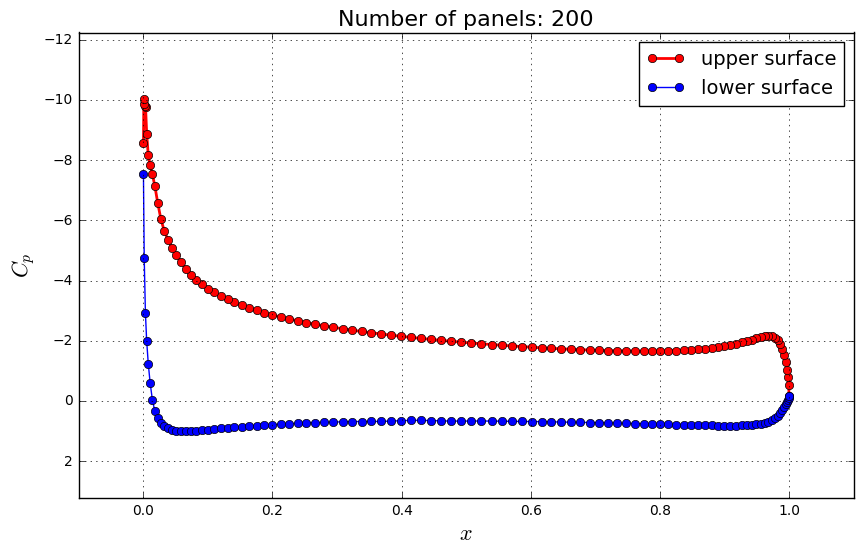

In [44]:
# plot surface pressure coefficient
val_x, val_y = 0.1, 0.2
x_min = min( panel.xa for panel in panels )
x_max = max( panel.xa for panel in panels )
cp_min = min( panel.cp for panel in panels )
cp_max = max( panel.cp for panel in panels )
x_start, x_end = x_min-val_x*(x_max-x_min), x_max+val_x*(x_max-x_min)
y_start, y_end = cp_min-val_y*(cp_max-cp_min), cp_max+val_y*(cp_max-cp_min)

pyplot.figure(figsize=(10, 6))
pyplot.grid(True)
pyplot.xlabel(r'$x$', fontsize=16)
pyplot.ylabel(r'$C_p$', fontsize=16)
pyplot.plot([panel.xc for panel in panels if panel.loc == 'upper'], 
         [panel.cp for panel in panels if panel.loc == 'upper'],
         label='upper surface',
         color='r', linestyle='-', linewidth=2, marker='o', markersize=6)
pyplot.plot([panel.xc for panel in panels if panel.loc == 'lower'], 
         [panel.cp for panel in panels if panel.loc == 'lower'], 
         label= 'lower surface',
         color='b', linestyle='-', linewidth=1, marker='o', markersize=6)
pyplot.legend(loc='best', prop={'size':14})
pyplot.xlim(x_start, x_end)
pyplot.ylim(y_start, y_end)
pyplot.gca().invert_yaxis()
pyplot.title('Number of panels: {}'.format(panels.size), fontsize=16);

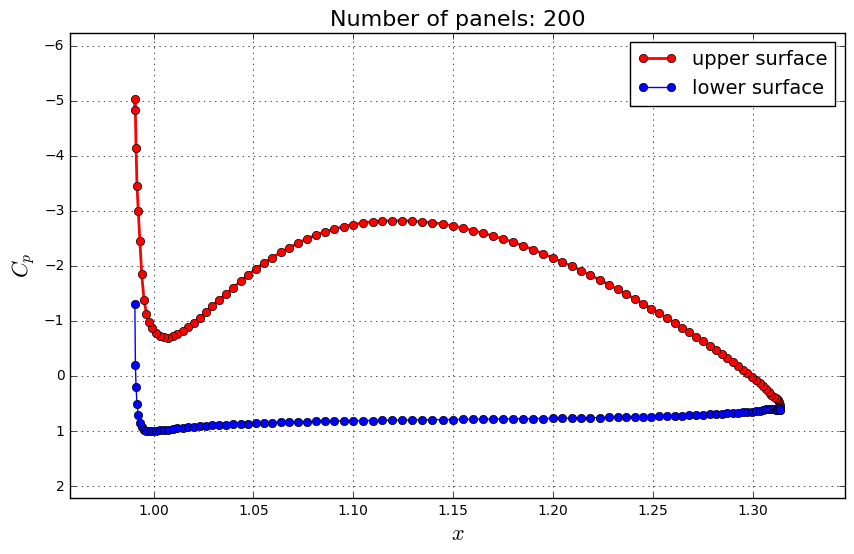

In [31]:
# plot surface pressure coefficient
val_x, val_y = 0.1, 0.2
x_min = min( panel.xa for panel in flappanels )
x_max = max( panel.xa for panel in flappanels )
cp_min = min( panel.cp for panel in flappanels )
cp_max = max( panel.cp for panel in flappanels )
x_start, x_end = x_min-val_x*(x_max-x_min), x_max+val_x*(x_max-x_min)
y_start, y_end = cp_min-val_y*(cp_max-cp_min), cp_max+val_y*(cp_max-cp_min)

pyplot.figure(figsize=(10, 6))
pyplot.grid(True)
pyplot.xlabel(r'$x$', fontsize=16)
pyplot.ylabel(r'$C_p$', fontsize=16)
pyplot.plot([panel.xc for panel in flappanels if panel.loc == 'upper'], 
         [panel.cp for panel in flappanels if panel.loc == 'upper'],
         label='upper surface',
         color='r', linestyle='-', linewidth=2, marker='o', markersize=6)
pyplot.plot([panel.xc for panel in flappanels if panel.loc == 'lower'], 
         [panel.cp for panel in flappanels if panel.loc == 'lower'], 
         label= 'lower surface',
         color='b', linestyle='-', linewidth=1, marker='o', markersize=6)
pyplot.legend(loc='best', prop={'size':14})
pyplot.xlim(x_start, x_end)
pyplot.ylim(y_start, y_end)
pyplot.gca().invert_yaxis()
pyplot.title('Number of panels: {}'.format(flappanels.size), fontsize=16);

In [32]:
cl=0


for i,panel in enumerate(allpanels):
    cl-= panel.cp*panel.length*numpy.sin(panel.beta)


print '--> Lift coefficient: Cl = %.3f' % cl       
    

--> Lift coefficient: Cl = 3.954
